# Hands-On Deep Learning modelo N-HiTS para series de tiempo
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%201%20-%20Time%20Series/nhits-time-series.ipynb)

En este notebook vamos a usar la arquitectura N-HiTS o Neural Hierarchical Interpolation For Tiem Series Forecasting. Esta es una técnica que al momento de implementar este notebook es un modelo SOTA para forecasting de horizontes largos con Deep Learning. Primero, vamos a correr un ejemplo con datos sintéticos y luego vamos a aplicarlo a nuestro ya conocido dataset del clima y realizar una comparación final con nuestros mejores modelos hasta el momento.

### Referencias
- [N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting, Challu et.al (2022)](https://arxiv.org/abs/2201.12886)

## Pytorch Forecasting
Para este ejercicio, vamos a utilizar una nueva libreria llamada [pytorch forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/index.html) la cual ya implementa por nosotros este modelo, junto con otros modelos avanzados para series de tiempo. Esta librería además se ajusta muy bien al resto de herramientas que ya hemos estado utilizando, por lo que no debería suponer un mayor problema adaptarse a esta.


In [1]:
import pkg_resources
import warnings
import os

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

datasets_path = './datasets/' if IN_COLAB else '../datasets'
# Para guardar modelos entrenados y re-utilizarlos luego
models_path = os.path.join(os.getcwd(), 'models')
os.makedirs(models_path, exist_ok=True)

In [2]:
!test '{IN_COLAB}' = 'True' && wget https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%201%20-%20Time%20Series/requirements.txt  && pip install -r requirements.txt

In [3]:
!test '{IN_COLAB}' = 'True' && wget https://tinyurl.com/3aamktz3 -O datasets.zip && unzip datasets.zip

Primero, generemos nuestro conjunto de datos sintético, veremos que la librería ofrece funciones para facilitarnos la tarea. Sin embargo, algo a tener en cuenta es la estructura de los datos obtenidos. Veremos que generaremos 2 series, pero estas van a estar aplanadas. Esto es asi pues la librería trabaja esperando los datos de esta manera.

In [4]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, MQF2DistributionLoss

# Creamos un dataset sintético de 4 series de 400 pasos cada una y un patrón estacional de 10
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=4, seed=123)
data['date'] = pd.Timestamp("2024-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head(21)

,series,time_idx,value,date
0,0,0,0.000000,2024-01-01
1,0,1,0.345117,2024-01-02
2,0,2,0.615208,2024-01-03
3,0,3,0.852250,2024-01-04
4,0,4,1.139137,2024-01-05
5,0,5,1.463804,2024-01-06
6,0,6,1.317917,2024-01-07
7,0,7,1.784141,2024-01-08
8,0,8,1.484581,2024-01-09
9,0,9,1.642288,2024-01-10


Ahora analicemos visualmente las series generadas. Podemos pivotar el dataframe obtenido para que cada serie sea una columna independiente y asi poder graficar más fácil.

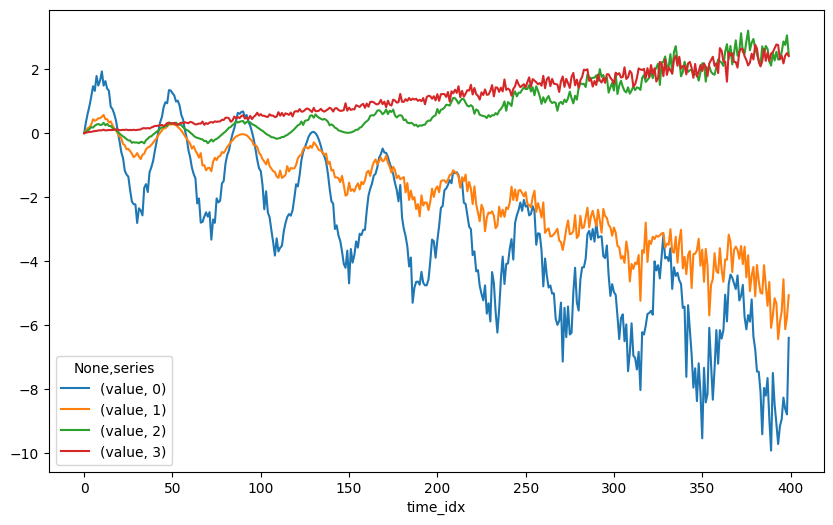

In [5]:
pivot_data = pd.pivot_table(data, values=['value'], index=['time_idx'], columns=['series'])
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
pivot_data.plot(ax=ax)
plt.show()

In [6]:
# El horizonte de tiempo del cual se calculará la predicción, es el tamaño de la secuencia de entrada
max_encoder_length = 60
# El horizonde de tiempo de la PREDICCIÓN, cuantos pasos de tiempo se pretenden pronosticar en un solo momento.
max_prediction_length = 20

# Definimos el corte para el training y testing set
# Dejarémos 100 ejemplares para validación
training_cutoff = data['time_idx'].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    # Solamente los datos cuyo indice de tiempo sea inferior al corte serán usados para el entrenamiento
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='value',
    categorical_encoders={'series': NaNLabelEncoder().fit(data.series)},
    group_ids=['series'],
    time_varying_unknown_reals=['value'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length
)

# Podemos reutilizar las definiciones del training set y definir el validation set con los mismos datos.
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=6)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=6)

Las Clase TimeSeriesDataset de Pytorch Forecasting implementa muchas utilidades automáticamente para el pre-procesamiento de los datos. Por ejemplo, automáticamente prepara las secuencias y las ventanas móviles, también se encarga de estandarizar los valores, codificar los valores categóricos, etc.

El único requisito es que el dataset de entrada, si tiene más de una serie, este debe estar aplanado, es decir, si las series las tenemos en diferentes columnas, estas deben pasar a ser filas, distinguidas por un campo de agrupamiento. Pytorch Forecasting espera que se utilice esta clase para sus modelos.

Ahora definimos un baseline con un modelo simple que hace predicciones basadas en el último valor obtenido, es en cierta forma similar a lo que hacíamos con un modelo tipo MA. Este paso nos permite saber si lo que vamos a hacer después es realmente mejor que un enfoque minimalista como este.

Algo para tener en cuenta y de las peculiaridades de la libreria es que si bien ofrece unas facilidades, como ofrecer la opción de retornar los valores $y$ verdaderos, la forma del tensor difiere del de las predicciones cuando trabajamos con series multi-variadas, por lo que debemos estar pendientes de reajustar las dimensiones. Sin embargo, es de esperarse que la cantidad de elementos sea la misma entre amos tensores, por lo que el ajuste debería funcionar sin problemas.

In [7]:
baseline_predictions = Baseline().predict(validation, trainer_kwargs=dict(accelerator='gpu'), return_y=True)
# output tiene un shape de (192, 5), son 192 secuencias y 5 pasos de tiempo de predicción para cada una.
# Aquí encontraremos predicciones para AMBAS series.
# el y retornado aquí, tiene un shape de (64, 15), que codifican predicciones para ambas series en sus 5 pasos de tiempo
# debemos hacer reshape de este tensor a (192, 5) para poder calcular la métrica 
SMAPE()(baseline_predictions.output, baseline_predictions.y[0].reshape(baseline_predictions.output.shape))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.1837, device='cuda:0')

## Modelo NHiTS - Neural Hierarchical Interporaltion for Tiem Series Forecasting

![](../assets/NHiTS-Architecture.png)

Ahora procedemos a crear un modelo NHiTS a partir del dataset de entrenamiento. La clase `NHiTS` ya implementa la arquitectura de red por nosotros, simplemente debemos pasar los hiperparámetros del modelo  para su entrenamiento.

Nótese el cambio de función de pérdida, aquí usaremos $MQF^2$ o Multivariate Quantile Function Forecaster, esta función de pérdida es de reciente aplicación y en lugar de calcular la diferencia por puntos, como lo hemos estado haciendo con $MSELoss$, lo que hace es calcular la diferencia entre quantiles de las distribuciones de valores predichos y futuros, de esta manera el modelo se concentra en aprender mas sobre la distribución de valores que de puntos individuales, haciendo las predicciones mas robustas y a la vez suaves. 

Para más información consultar el paper original [Kan et.al. (2022)](https://arxiv.org/abs/2202.11316)

In [8]:
pl.seed_everything(123)
trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Ahora procedemos a entrenar el modelo como usualmente lo hemos hecho.

In [9]:
%%time
from lightning.pytorch.loggers import TensorBoardLogger

tb_logger = TensorBoardLogger('tb_logs', name='NHiTS-Synthetic')
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
    logger=tb_logger
)
trainer.fit(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 5.1 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 35.7 K
---------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 10.51it/s, v_num=13, train_loss_step=0.0371, val_loss=0.0823, train_loss_epoch=0.0393]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 10.18it/s, v_num=13, train_loss_step=0.0371, val_loss=0.0823, train_loss_epoch=0.0393]
CPU times: user 5.22 s, sys: 3.51 s, total: 8.72 s
Wall time: 10.2 s


Ahora realicemos unas predicciones en el set de validación, en este caso particular vamos a volver a usar el $MSELoss$ ya que estamos fuera del entrenamiento y quizás necesitemos comparar los resultados con otros modelos (a manera de ejemplo)

In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)
best_model.eval()
predictions = best_model.predict(validation, trainer_kwargs={'accelerator': 'cpu'}, return_x=True, return_y=True, return_index=True)
nn.MSELoss()(predictions.output, predictions.y[0].reshape(predictions.output.shape))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3321)

Algo para aclarar, cuando usamos métricas como el $MSELoss$, la magnitud del valor solamente tiene significado cuando se lo compara con otros modelos, en este caso particular $8.4658$ no quiere decir que está bien o mal, naturalmente entre más cercano a cero este mejor, pero nunca va a ser cero, es por eso que este valor solo tiene sentido si se lo compara con otros modelos, por lo que no vamos a elaborar más sobre este resultado, solo mostrar como obtenerlo.

### Utilizando el modelo
Ahora vamos a usar el modelo y comparar sus predicciones con el historico. Para ello vamos a cargar el mejor checkpoint de entrenamiento y luego hacer predicciones en el conjunto de validación.

Primero, observemos su calidad predictiva en algunos ejemplares de entrenamiento particulares. Recordemos que hemos definido unos horizontes de entrada y salida, lo que veremos a continuación son ejemplares aislados de varios puntos de las series de ejemplo con las que entrenamos (2).

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


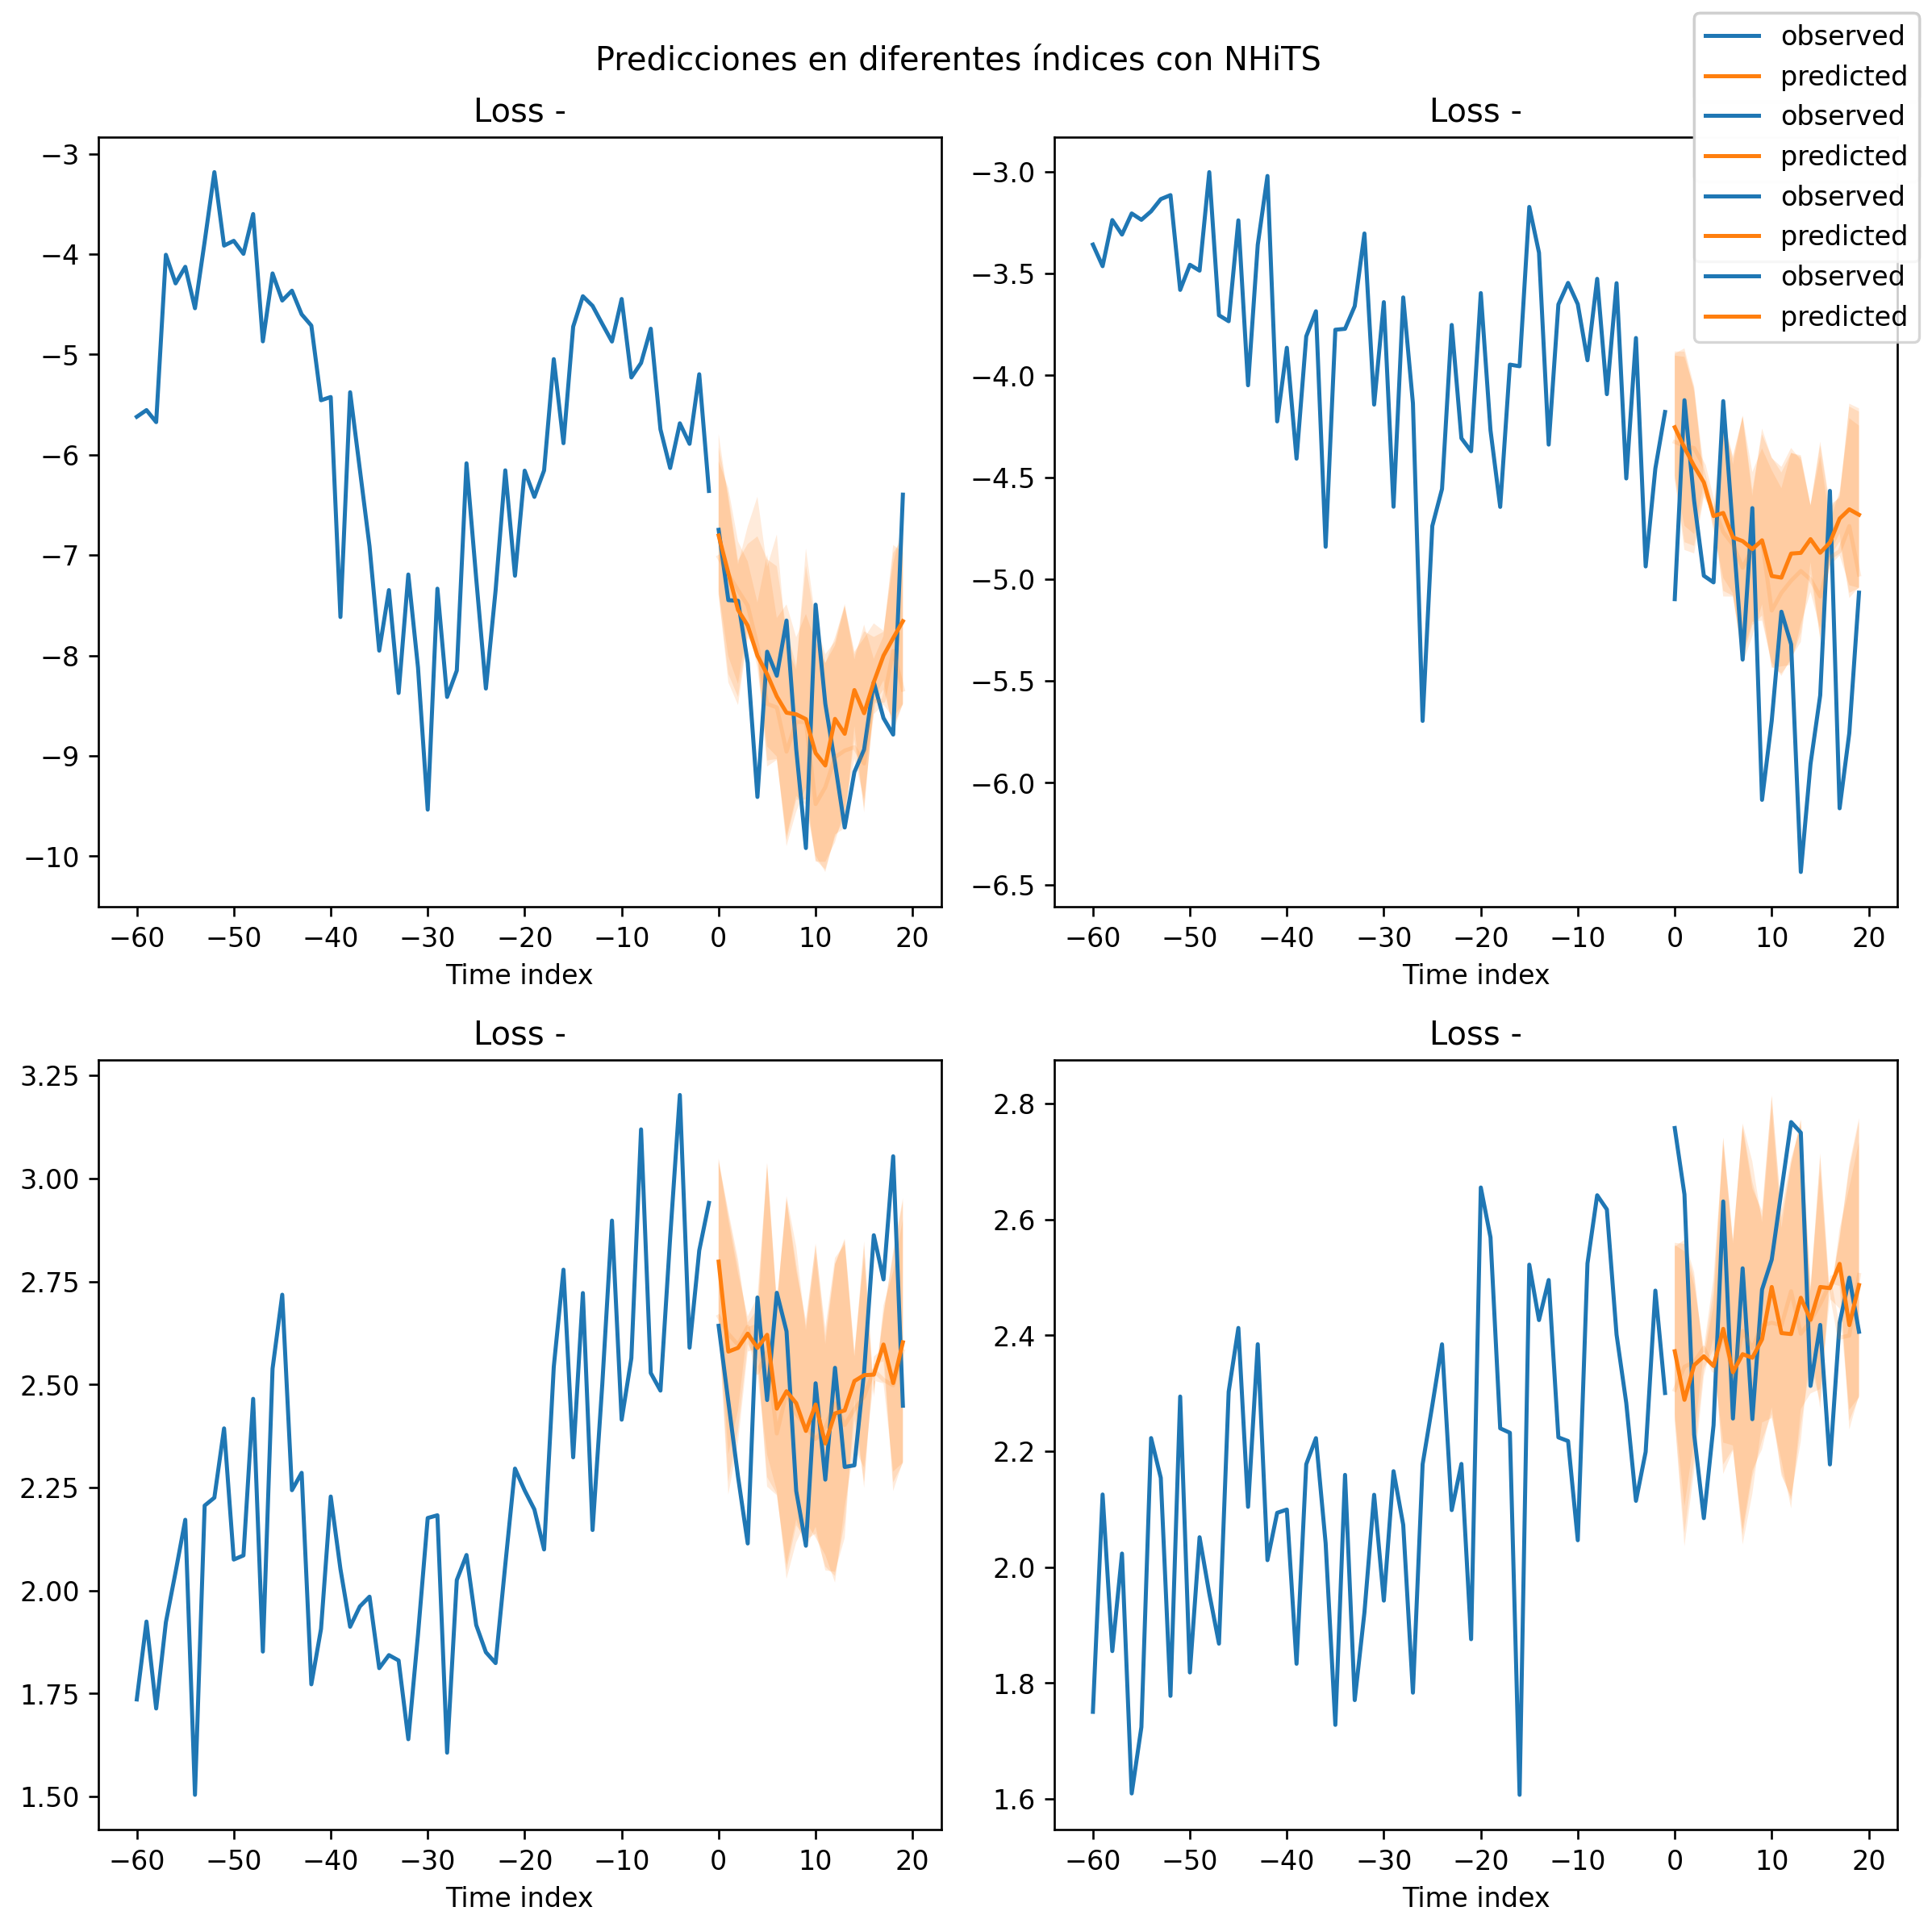

In [11]:
raw_predictions = best_model.predict(val_dataloader, mode='raw', return_x=True, trainer_kwargs={'accelerator': 'cpu'})

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=240, figsize=(10, 10))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, ax=ax, add_loss_to_title=True)

plt.suptitle('Predicciones en diferentes índices con NHiTS')
plt.tight_layout()
plt.show()

El modelo parece comportarse bastante bien. Ahora miremos como se comporta haciendo forecast sobre todo el conjunto de validación.

Recordemos una vez más que entrenamos con 2 series y que nuestro modelo es multi-variado, es decir no solo consume multiples series sino que hace predicciones sobre todas ellas al mismo tiempo, por lo que vamos a observar como se comporta por cada una.

Recordemos además que nuestros dataframe original estaba aplanado, por lo que devemos pivotarlo para obtener los valores por cada paso de tiempo en una columna independiente.

In [12]:
predictions = best_model.predict(validation, return_index=True, return_x=True, return_y=True, trainer_kwargs={'accelerator': 'gpu'})

pv = pd.pivot_table(data[lambda x: x.time_idx >= training_cutoff], values=['value'], index=['time_idx'], columns=['series'])
pv.head(15)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


value                              
series           0         1         2         3
time_idx                                        
379      -6.360787 -4.180167  2.940551  2.300545
380      -6.748162 -5.098638  2.642308  2.757904
381      -7.448992 -4.122299  2.458090  2.643307
382      -7.455431 -4.616403  2.276137  2.228756
383      -8.073710 -4.983723  2.114178  2.084601
384      -9.410135 -5.016278  2.711032  2.244912
385      -7.962832 -4.126664  2.462189  2.631188
386      -8.201946 -4.757888  2.722526  2.256504
387      -7.652173 -5.395074  2.628883  2.515743
388      -8.935189 -4.651823  2.241527  2.255360
389      -9.919538 -6.083435  2.108651  2.479004
390      -7.493989 -5.695336  2.502907  2.530836
391      -8.481317 -5.160284  2.269049  2.649804
392      -9.074485 -5.320177  2.540395  2.768179
393      -9.714594 -6.437356  2.299778  2.749841

Finalmente, observemos una comparación de lo predicho vs lo real punto por punto:

##### Nota
Como nuestro modelo predice 20 pasos de tiempo en el futuro, para poder hacer este gráfico, solo vamos a tener en cuenta el primer paso de tiempo que predice el modelo, eso si, por cada paso de tiempo del conjunto de validación.

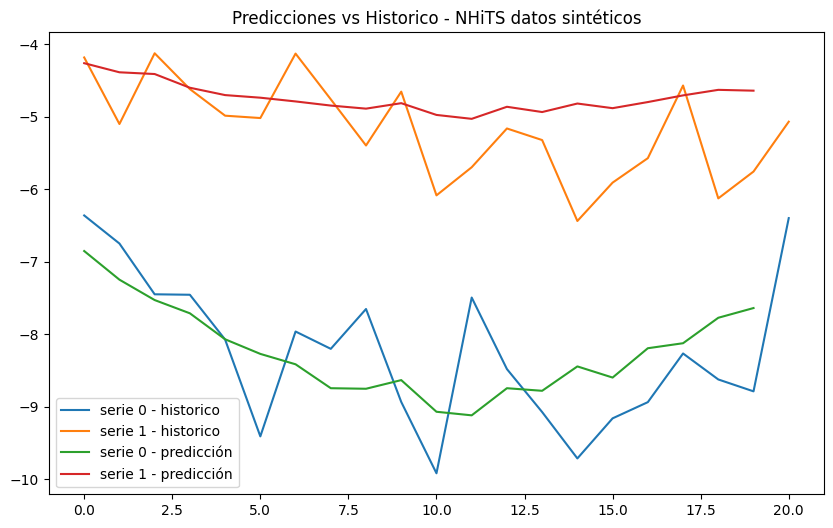

In [13]:
y0 = pv[('value', 0)].reset_index(drop=True)
y1 = pv[('value', 1)].reset_index(drop=True)
yhat = predictions.output.cpu().numpy()

fig = plt.figure(figsize=(10, 6))
plt.plot(y0, label='serie 0 - historico')
plt.plot(y1, label='serie 1 - historico')
# Tomamos únicamente el primer pronóstico de cada ejemplar para facilitar el gráfico
plt.plot(yhat[0, :], label='serie 0 - predicción')
plt.plot(yhat[1, :], label='serie 1 - predicción')
plt.title('Predicciones vs Historico - NHiTS datos sintéticos')
plt.legend()
plt.show()

El modelo se asemeja significativamente a la serie original!

## Serie de tiempo del clima del laboratorio Max Planck

Ahora vamos a regresar al caso del clima de los notebooks pasados utilizando el modelo NHiTS. El dataset lo pueden encontrar aquí: https://www.kaggle.com/datasets/arashnic/max-planck-weather-dataset/data. Debido a que el dataset son 42MB y requiere autenticación en kaggle para descargar, esto deberán hacerlo manualmente antes de continuar con el notebook.

El objetivo de este caso es modelar la serie de tiempo de la temperatura atmosférica en grados centigrados. Para ello, contamos no solo con datos desde el 2009 al 2016 sobre la temperatura misma sino de otras mediciones como la presión atmosférica, presión de vapor, humedad, entre otros. Los datos fueron tomados especificamente en la estación del clima Beuternberg

### Enlaces de interés
- [Max-Planck Institut](https://mpimet.mpg.de/en/research/observations)
- [Max-Planck Institut - Weather Station](https://www.bgc-jena.mpg.de/wetter/)
- [Weather Station Beutenberg](https://www.bgc-jena.mpg.de/wetter/towercam.html)
- [Beutenberg Campus](https://maps.app.goo.gl/fGJX1T9bjTJhueqJ9)

In [14]:
import pandas as pd
import numpy as np

# El dataset cuenta con temperatura en grados Kelvin también
# Pero no queremos incluir esta columna porque está midiendo exactamente lo mismo
columns = ['T (degC)', 'p (mbar)', 'VPact (mbar)', 'sh (g/kg)', 'Tdew (degC)', 'H2OC (mmol/mol)']
# Cambiar según la localización del archivo.
dataset = pd.read_csv(os.path.join(datasets_path, 'max_planck_weather_ts.csv'))[columns].reset_index()
dataset = dataset.rename(columns={'index': 'time_idx'})

dataset.head(15)

,time_idx,T (degC),p (mbar),VPact (mbar),sh (g/kg),Tdew (degC),H2OC (mmol/mol)
0,0,-8.02,996.52,3.11,1.94,-8.90,3.12
1,1,-8.41,996.57,3.02,1.89,-9.28,3.03
2,2,-8.51,996.53,3.01,1.88,-9.31,3.02
3,3,-8.31,996.51,3.07,1.92,-9.07,3.08
4,4,-8.27,996.51,3.08,1.92,-9.04,3.09
5,5,-8.05,996.50,3.14,1.96,-8.78,3.15
6,6,-7.62,996.50,3.26,2.04,-8.30,3.27
7,7,-7.62,996.50,3.25,2.03,-8.36,3.26
8,8,-7.91,996.50,3.15,1.97,-8.73,3.16
9,9,-8.43,996.53,3.00,1.88,-9.34,3.02


Tengamos en cuenta que no podemos utilizar este dataset tal como está. Primero debemos aplanarlo para que pueda ser usado por el `TimeSeriesDataSet` y el resto de los modelos en pytorch forecasting. 

In [15]:
unpivoted_dataset = pd.melt(dataset, id_vars=['time_idx'], var_name='Measurement', value_name='Value')
unpivoted_dataset.head(10)

,time_idx,Measurement,Value
0,0,T (degC),-8.02
1,1,T (degC),-8.41
2,2,T (degC),-8.51
3,3,T (degC),-8.31
4,4,T (degC),-8.27
5,5,T (degC),-8.05
6,6,T (degC),-7.62
7,7,T (degC),-7.62
8,8,T (degC),-7.91
9,9,T (degC),-8.43


Otra de las ventajas de la libreria es que nos permite otras opciones para poder crear los conjuntos de entrenamiento, validación y prueba. Lo que debemos hacer es definir los indices donde empeiza y termina cada conjunto.

In [16]:
# create dataset and dataloaders
max_encoder_length = 200
max_prediction_length = 50

# definimos los conjuntos a partir de los indices
# el conjunto de entrenamiento usará el 80% del dataset original
# y el otro 20% será partido en 10% y 10% entre el conjunto de validación y prueba
training_cutoff = int(unpivoted_dataset["time_idx"].max() * 0.8)
testing_cutoff = int(unpivoted_dataset["time_idx"].max() * 0.9)

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    # Todo registro cuyo time step sea inferior al umbral de entrenamiento
    unpivoted_dataset[unpivoted_dataset.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Value",
    categorical_encoders={"Measurement": NaNLabelEncoder().fit(unpivoted_dataset.Measurement)},
    group_ids=["Measurement"],
    time_varying_unknown_reals=["Value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(
    training, 
    # Todo registro cuyo time step este entre el umbral de entrenamiento y el umbral de prueba
    unpivoted_dataset[(unpivoted_dataset.time_idx > training_cutoff) & (unpivoted_dataset.time_idx <= testing_cutoff)], 
    min_prediction_idx=training_cutoff + 1
    )

testing = TimeSeriesDataSet.from_dataset(
    training, 
    # Todo registro cuyo time step sea mayor al umbral de prueba
    unpivoted_dataset[unpivoted_dataset.time_idx > testing_cutoff], 
    min_prediction_idx=testing_cutoff + 1
    )

testing_y = torch.stack([y[0] for _, y in testing], dim=0)

batch_size = 256
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=6)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=6)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=6)

Un detalle particular con este tipo de datasets es que codifica el identificador de las series, que es un texto, en valores numéricos. Como nos interesa solamente la temperatura, debemos poder reconocer su id para cuando hagamos las predicciones ya que este modelo hará predicciones por todas las series obtenidas.

El tipo de serie (Measurement) es categórico y fue codificado para ser usado en la red. Hallemos cual es el código de la serie de interes, la temperatura en grados centigrados.

In [17]:
measurement_codes = training.categorical_encoders['Measurement'].transform(columns)
list(zip(measurement_codes, columns))

[(1, 'T (degC)'),
 (4, 'p (mbar)'),
 (3, 'VPact (mbar)'),
 (5, 'sh (g/kg)'),
 (2, 'Tdew (degC)'),
 (0, 'H2OC (mmol/mol)')]

Debemos recordar que nuestra serie de interés es la #1

### Entrenamiento

Para el entrenamiento vamos a hacer unos cambios frente a los modelos que hemos estado entrenando hasta ahora. Primero, usaremos un learning rate más grande pero contra peso, definiremos un `weight_decay` para añadir regularización a la perdida. En cuanto a optimizador, vamos a utilizar AdamW. Finalmente, durante el entrenamiento, vamos a utilizar gradient clipping para evitar que estos crezcan demasiado.

In [18]:
%%time
pl.seed_everything(123)

net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)


tb_logger = TensorBoardLogger('tb_logs', name='NHiTS-Weather')
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=100,
    enable_checkpointing=True,
    logger=tb_logger
)
trainer.fit(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


Seed set to 123


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 10.0 K
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 80.3 K
---------------------------------------------------------
90.3 K    Trainable params
0         Non-trainable params
90.3 K    Total params
0.361     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s, v_num=14, train_loss_step=0.107, val_loss=0.113, train_loss_epoch=0.111]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s, v_num=14, train_loss_step=0.107, val_loss=0.113, train_loss_epoch=0.111]
CPU times: user 7min 2s, sys: 18.7 s, total: 7min 20s
Wall time: 7min 28s


In [19]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir tb_logs/

El entrenamiento luce muy bien, ahora procedamos a evaluar el modelo en el conjunto de prueba.
En este caso, como en todos los demás modelos anteriores hemos estado utilizando $MSE$ como métrica, vamos a continuar con esta métrica. Técnicamente, no es obligatorio utilizar la misma pérdida de entrenamiento en la validación y como hemos establecido, la idea de esta métrica es poder comparar entre modelos.

In [21]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)
best_model.eval()
predictions = best_model.predict(test_dataloader, trainer_kwargs={'accelerator': 'gpu'})
nn.MSELoss()(predictions.cpu(), testing_y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.7308)

Hemos obtenido una métrica significativamente inferior a la de nuestros modelos anteriores lo cual indica una buena señal. Finalmente, como es de esperarse, vamos a graficar las predicciones y compararlas con el histórico uno a uno para apreciar la calidad del modelo obtenido.

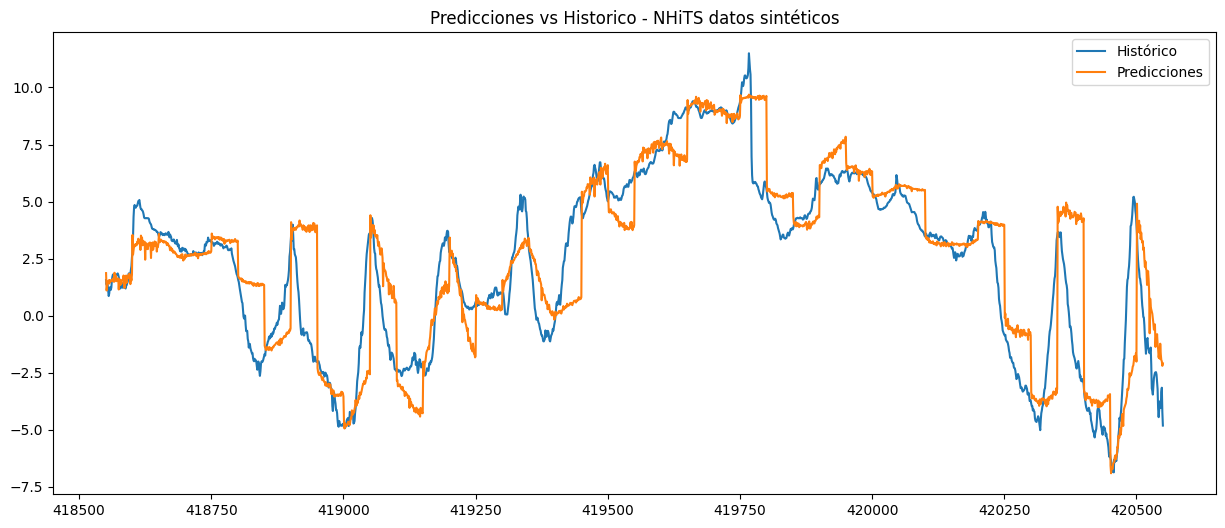

In [22]:
# pasos de tiempo que vamos a observar
steps = 2000

last_index = (len(testing) // 6) -1 # Tenemos 6 series 

# Como hacemos predicciones de a 20 pasos de tiempo y cada ejemplar es un sliding window de 1,
# Para reconstruir todas las predicciones de los últimos 'steps',
# Necesitamos generar una secuencia con gaps de a 20 (max_prediction_length)
# esto resultará en los índices que debemos extraer de las predicciones para reconstruir la serie.
to_extract = list(reversed(range(last_index, last_index - steps, -max_prediction_length)))

# vamos a observar los últimos pasos del historico de la temperatura
original = dataset.iloc[-steps:]['T (degC)']

# El shape original de predictions es (251016, 20) es decir (# de ejemplares, horizonte de pronóstico)
# Necesitamos reformarlo para obtener las predicciones por serie, es decir (# de serie, # de ejemplares, horizonte de pronóstico)
# Recordemos que nuestra serie de interés es la temperatura, cuyo id es 1 según el encoder, entonces extraemos esta serie
# Luego extraemos los ejemplares correspondientes a los pasos de tiempo para reconstruir la serie a partir de todas las predicciones
# Finalmente las concatenamos para formar un solo arreglo de tamaño 'steps'
y_hat = np.concatenate(predictions.cpu().numpy().reshape(6, -1, max_prediction_length)[1, to_extract, :])

# Como y_hat no tiene los indices de tiempo, generamos un rango de tiempo a partir del indice del historico que vamos a observar
time_range = np.arange(original.index[0], original.index[0] + steps)

fig = plt.figure(figsize=(15, 6))
plt.plot(original, label='Histórico')
plt.plot(time_range, y_hat, label='Predicciones')
plt.title('Predicciones vs Historico - NHiTS datos sintéticos')
plt.legend()
plt.show()

Hemos obtenido un modelo casi perfecto, incluso mejor que el modelo SARIMAX. Solamente quedan unos errores mínimos en algunos pasos de tiempo. Han habido varios elementos que han contribuido a la calidad de este modelo:

1. La arquitectura de la red, que contempla las relaciones temporales hacia adelante y hacia atrás, además de que por diseño, los stacks de la red capturan diferentes componentes de la serie, que al unirse ajustan a los valores históricos.
2. La función de perdida $MQF^2$ que busca trabajar sobre los quantiles y la distribución de los datos en lugar de cada punto de forma individual, lo cual hace que el modelo resultante sea mucho más robusto y con mejor capacidad de generalización.
3. Los ajustes al optimizador y el proceso de entrenamiento, en particular la regularización, que limitaría al modelo de tener un gran error de sesgo (overfitting), además del gradient clipping.
4. La librería facilita el patrón encoder-decoder al momento de lidiar con los datos, lo cual le facilita al modelo el crear una mejor representación de los datos en un espacio vectorial donde puede computar los patrones especiales de la red. Esto es algo que hasta ahora no habíamos hecho.

## Conclusiones
- Tanto NHiTS junto con la función de pérdida $MQF^2$, son técnicas punteras y modernas al momdento de elaborar este notebook (2024) las cuales son significativamente poderosas para trabajar con problemas de series de tiempo.
- Esta técnica nos permite incluso hacer pronósticos a largo plazo en el tiempo y aún así conservar una gran congruencia con los datos históricos. Aunque es bueno ser cautos, ya que durante el entrenamiento de este modelo, la red fue alimentada con los mismos ejemplares tanto en el input como en el target pero en diferentes ventanas de tiempo, esto podría significar que el modelo se ha aprendido los datos de memoria.
- El poder utilizar el dataset completo abre la posibilidad de entrenar modelos con muchos más datos de los que técnicas tradicionales requieren como SARIMAX, lo cual no solo brinda al modelo más ejemplares para aprender, sino que permite entrenar con una gran cantidad de datos y no estaríamos limitados a un pequeño sub conjunto. Claro está, al coste del tiempo de entrenamiento.
- Pytorch forecasting es una librería muy útil que implementa no solo este modelo, sino otros similar e incluso basados en Transformers y encima de eso, pone a disposición varias utilidades para trabajar con datos temporales lo cual facilita mucho la preparación y el manejo de los mismos. Sin embargo...
- Es necesario entender muy bien como funciona la libreria y que hace por debajo pues se pueden cometer errores muy facilmente al interpretar los resultados o intentar manipular tanto las entradas como las salidas para interpretarlas.
- A pesar de que en este caso, NHiTS ha resultado el modelo mas adecuado, comparado con todos los demás que hemos visto, aún asi es importante conocer los demás puesto que, una vez mas, la complejidad del problema, la disponibilidad de los datos y el pre-procesamiento requerido varia entre caso y caso.

Con este notebook damos por finalizada la Unidad 1, Deep Learning aplicado para series de Tiempo.
Espero esta información les sea de utilidad. Muchas gracias por llegar hasta acá.